In [ ]:
#30/10/2025
!pip install scikit-image matplotlib opencv-python-headless


In [ ]:
!pip install -q kaggle tensorflow matplotlib seaborn pandas pillow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR ="/content/drive/MyDrive/indianfood"

In [ ]:
import os
print(os.listdir(DATA_DIR))

['india_food_21_small']


In [ ]:
# Correct dataset base path
DATA_PATH = "/content/drive/MyDrive/indianfood/india_food_21_small"

# Collect image file paths
image_paths = []
labels = []

for folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.jpg','.jpeg','.png')):
                image_paths.append(os.path.join(folder_path, file))
                labels.append(folder)

# Create DataFrame
image_df = pd.DataFrame({
    "filepath": image_paths,
    "label": labels
})

print("Total images:", len(image_df))
image_df.head()


Total images: 452


,filepath,label
0,/content/drive/MyDrive/indianfood/india_food_2...,idli
1,/content/drive/MyDrive/indianfood/india_food_2...,idli
2,/content/drive/MyDrive/indianfood/india_food_2...,idli
3,/content/drive/MyDrive/indianfood/india_food_2...,idli
4,/content/drive/MyDrive/indianfood/india_food_2...,idli


TRAIN TEST SPLIT

In [ ]:
# Split dataset
train_df, val_df = train_test_split(
    image_df,
    test_size=0.2,
    stratify=image_df['label'],
    random_state=42
)

len(train_df), len(val_df)


(361, 91)

In [ ]:
# Data generators
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

# Number of classes fix
num_classes = len(train_data.class_indices)
print("Classes:", num_classes)
print("Class Mapping:", train_data.class_indices)



Found 361 validated image filenames belonging to 21 classes.
Found 91 validated image filenames belonging to 21 classes.
Classes: 21
Class Mapping: {'butter_chicken': 0, 'butter_naan': 1, 'chicken_fried_rice': 2, 'chole_bhature': 3, 'dahi_bhalla': 4, 'dal_makhani': 5, 'gajar_halwa': 6, 'hilsa_fish_curry': 7, 'idli': 8, 'jalebi': 9, 'kachori': 10, 'kadai_paneer': 11, 'kulfi': 12, 'masala_dosa': 13, 'nalli_nihari': 14, 'pasta': 15, 'peda': 16, 'pizza': 17, 'rasgulla': 18, 'samosa': 19, 'vada_pav': 20}



define all 4 models




In [ ]:
def build_cnn():
    model = Sequential([
        Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
        MaxPooling2D(2,2),
        Conv2D(64,(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128,(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256,activation='relu'),
        Dropout(0.3),
        Dense(num_classes,activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mobilenet():
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
    base.trainable = False
    model = Sequential([base, GlobalAveragePooling2D(), Dense(num_classes, activation='softmax')])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_resnet():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
    base.trainable = False
    model = Sequential([base, GlobalAveragePooling2D(), Dense(num_classes, activation='softmax')])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_vgg16():
    base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
    base.trainable = False
    model = Sequential([base, Flatten(), Dense(256,activation='relu'), Dense(num_classes, activation='softmax')])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


training

In [ ]:
models = {
    "CNN_20": build_cnn(),
    "MobileNetV2_20": build_mobilenet(),
    "ResNet50_20": build_resnet(),
    "VGG16_20": build_vgg16()
}

results = {}

for name, model in models.items():
    print(f"\n🚀 Training {name} for 20 epochs...\n")

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=20,
        verbose=1
    )

    results[name] = (
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1]
    )

print("\n✅ Training Complete!")
results


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/tmp/ipython-input-4284065877.py:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training CNN_20 for 20 epochs...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 230s 18s/step - accuracy: 0.0344 - loss: 3.2888 - val_accuracy: 0.1209 - val_loss: 3.0152
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 620ms/step - accuracy: 0.1044 - loss: 2.9826 - val_accuracy: 0.1209 - val_loss: 2.8884
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 634ms/step - accuracy: 0.1072 - loss: 2.8423 - val_accuracy: 0.1429 - val_loss: 2.7303
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 639ms/step - accuracy: 0.2138 - loss: 2.6078 - val_accuracy: 0.1538 - val_loss: 2.6101
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 609ms/step - accuracy: 0.2214 - loss: 2.4603 - val_accuracy: 0.1978 - val_loss: 2.5909
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 690ms/step - accuracy: 0.3073 - loss: 2.1597 - val_accuracy: 0.1868 - val_loss: 2.6252
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 616ms/step - accuracy: 0.4242 - loss: 1.7841 - val_accuracy: 0.2747 - val_loss: 2.7011
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 646ms/step - accuracy: 0.5741 - loss: 1.3672 - val_accuracy: 0.

{'CNN_20': (0.9695290923118591, 0.2747252881526947),
 'MobileNetV2_20': (1.0, 0.7362637519836426),
 'ResNet50_20': (0.20775623619556427, 0.17582418024539948),
 'VGG16_20': (1.0, 0.593406617641449)}

In [ ]:
!ls "/content/drive/MyDrive/indianfood/india_food_21_small"


butter_chicken	    dal_makhani       kachori	    pasta     vada_pav
butter_naan	    gajar_halwa       kadai_paneer  peda
chicken_fried_rice  hilsa_fish_curry  kulfi	    pizza
chole_bhature	    idli	      masala_dosa   rasgulla
dahi_bhalla	    jalebi	      nalli_nihari  samosa


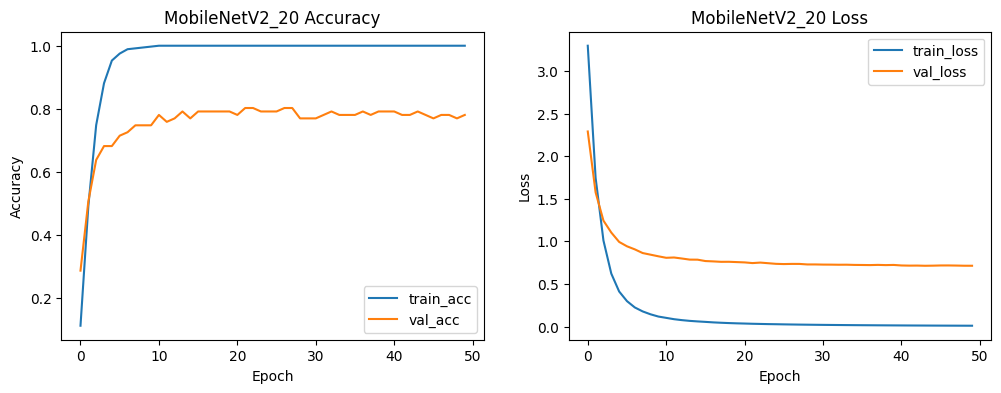

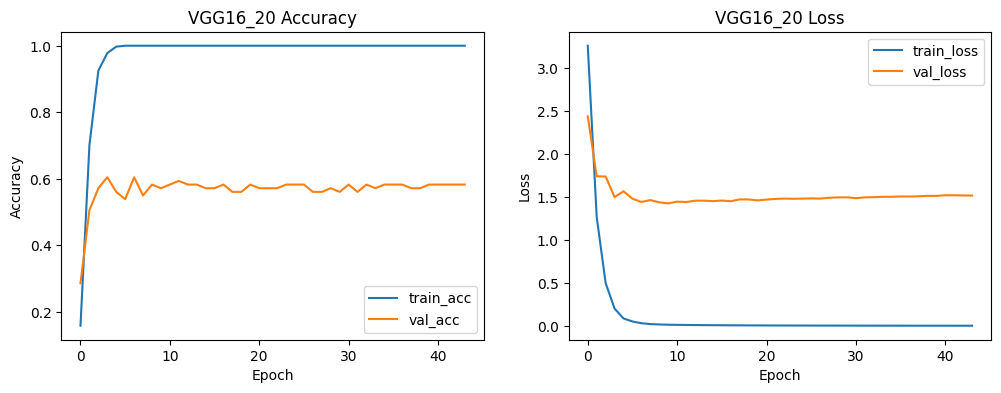

In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot for all models
for name, model in models.items():
    history = model.history  # Access history from training
    plot_history(history, name)


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


<Figure size 1000x1000 with 0 Axes>

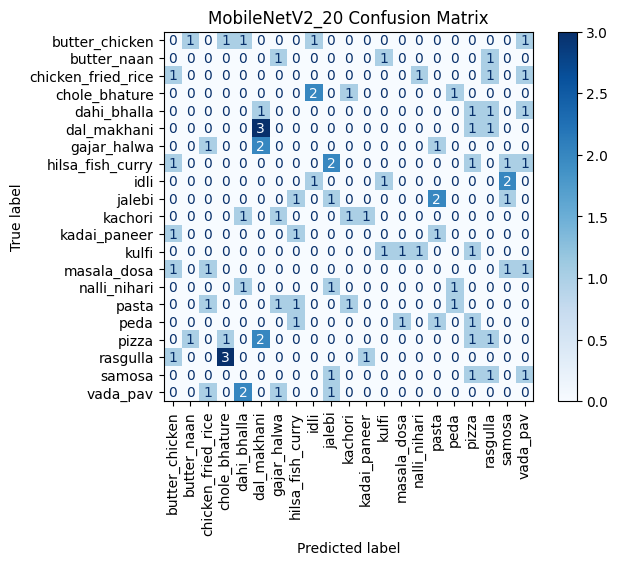

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step


<Figure size 1000x1000 with 0 Axes>

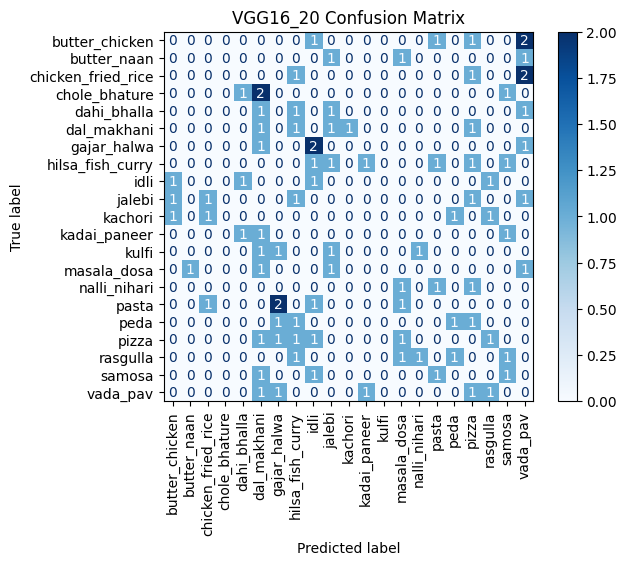

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, val_data, model_name):
    val_data.reset()  # Ensure batches start from beginning
    preds = model.predict(val_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_data.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(val_data.class_indices.keys()))

    plt.figure(figsize=(10,10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

# Plot confusion matrices for all models
for name, model in models.items():
    plot_confusion_matrix(model, val_data, name)


TESTING AND PREDICTION

Best model selected: MobileNetV2_20


Saving Screenshot 2025-11-05 225709.png to Screenshot 2025-11-05 225709.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


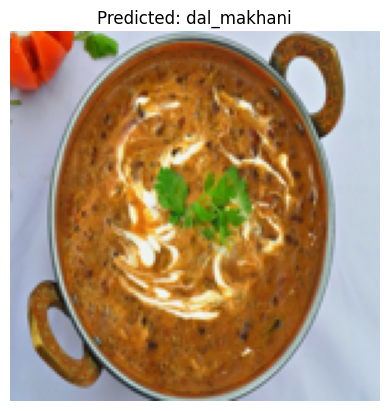

Prediction: dal_makhani


In [ ]:
from google.colab import files
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt

# Pick the best model automatically based on validation accuracy
best_model_name = max(results, key=lambda k: results[k][1])  # highest val_accuracy
best_model = models[best_model_name]
print(f"Best model selected: {best_model_name}")

# Function to predict
def predict_image_upload(model, target_size=(150,150)):
    uploaded = files.upload()  # opens file picker
    for filename in uploaded.keys():
        img_path = f"/content/{filename}"
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)
            img_array = np.array(img)/255.0
            img_array = np.expand_dims(img_array, axis=0)

            pred = model.predict(img_array)
            class_idx = np.argmax(pred, axis=1)[0]
            class_label = {v:k for k,v in train_data.class_indices.items()}[class_idx]

            plt.imshow(img)
            plt.title(f"Predicted: {class_label}")
            plt.axis('off')
            plt.show()

            print(f"Prediction: {class_label}")
        except UnidentifiedImageError:
            print("Cannot open the image. Make sure it is a valid image file.")

# Run the function
predict_image_upload(best_model)


In [ ]:
# Save best model
save_path = "/content/drive/MyDrive/indianfood/best_model.h5"
best_model.save(save_path)
print(f"Model saved at {save_path}")


Model saved at /content/drive/MyDrive/indianfood/best_model.h5


Best model selected: MobileNetV2_20


Saving Screenshot 2025-11-05 230013.png to Screenshot 2025-11-05 230013.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


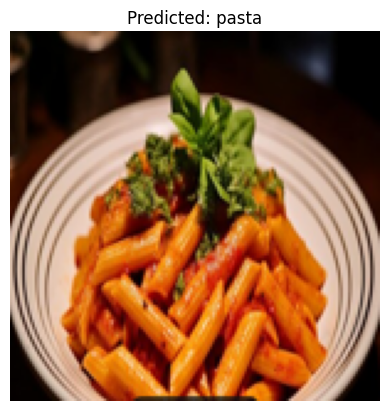

Prediction: pasta


In [ ]:
from google.colab import files
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt

# Pick the best model automatically based on validation accuracy
best_model_name = max(results, key=lambda k: results[k][1])  # highest val_accuracy
best_model = models[best_model_name]
print(f"Best model selected: {best_model_name}")

# Function to predict
def predict_image_upload(model, target_size=(150,150)):
    uploaded = files.upload()  # opens file picker
    for filename in uploaded.keys():
        img_path = f"/content/{filename}"
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)
            img_array = np.array(img)/255.0
            img_array = np.expand_dims(img_array, axis=0)

            pred = model.predict(img_array)
            class_idx = np.argmax(pred, axis=1)[0]
            class_label = {v:k for k,v in train_data.class_indices.items()}[class_idx]

            plt.imshow(img)
            plt.title(f"Predicted: {class_label}")
            plt.axis('off')
            plt.show()

            print(f"Prediction: {class_label}")
        except UnidentifiedImageError:
            print("Cannot open the image. Make sure it is a valid image file.")

# Run the function
predict_image_upload(best_model)

Best model selected: MobileNetV2_20


Saving Screenshot 2025-11-05 230245.png to Screenshot 2025-11-05 230245.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


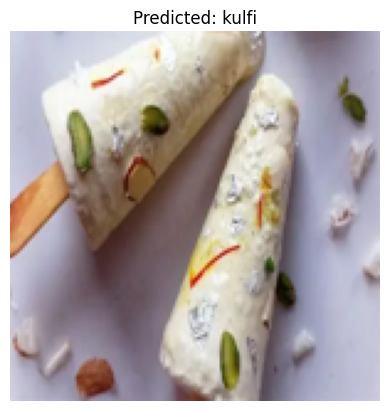

Prediction: kulfi


In [ ]:
from google.colab import files
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt

# Pick the best model automatically based on validation accuracy
best_model_name = max(results, key=lambda k: results[k][1])  # highest val_accuracy
best_model = models[best_model_name]
print(f"Best model selected: {best_model_name}")

# Function to predict
def predict_image_upload(model, target_size=(150,150)):
    uploaded = files.upload()  # opens file picker
    for filename in uploaded.keys():
        img_path = f"/content/{filename}"
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)
            img_array = np.array(img)/255.0
            img_array = np.expand_dims(img_array, axis=0)

            pred = model.predict(img_array)
            class_idx = np.argmax(pred, axis=1)[0]
            class_label = {v:k for k,v in train_data.class_indices.items()}[class_idx]

            plt.imshow(img)
            plt.title(f"Predicted: {class_label}")
            plt.axis('off')
            plt.show()

            print(f"Prediction: {class_label}")
        except UnidentifiedImageError:
            print("Cannot open the image. Make sure it is a valid image file.")

# Run the function
predict_image_upload(best_model)

Best model selected: MobileNetV2_20


Saving Screenshot 2025-11-05 230406.png to Screenshot 2025-11-05 230406.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


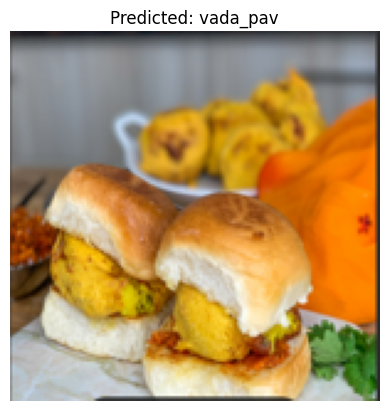

Prediction: vada_pav


In [ ]:
from google.colab import files
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt

# Pick the best model automatically based on validation accuracy
best_model_name = max(results, key=lambda k: results[k][1])  # highest val_accuracy
best_model = models[best_model_name]
print(f"Best model selected: {best_model_name}")

# Function to predict
def predict_image_upload(model, target_size=(150,150)):
    uploaded = files.upload()  # opens file picker
    for filename in uploaded.keys():
        img_path = f"/content/{filename}"
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)
            img_array = np.array(img)/255.0
            img_array = np.expand_dims(img_array, axis=0)

            pred = model.predict(img_array)
            class_idx = np.argmax(pred, axis=1)[0]
            class_label = {v:k for k,v in train_data.class_indices.items()}[class_idx]

            plt.imshow(img)
            plt.title(f"Predicted: {class_label}")
            plt.axis('off')
            plt.show()

            print(f"Prediction: {class_label}")
        except UnidentifiedImageError:
            print("Cannot open the image. Make sure it is a valid image file.")

# Run the function
predict_image_upload(best_model)

Best model selected: MobileNetV2_20


Saving Screenshot 2025-11-05 230525.png to Screenshot 2025-11-05 230525.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


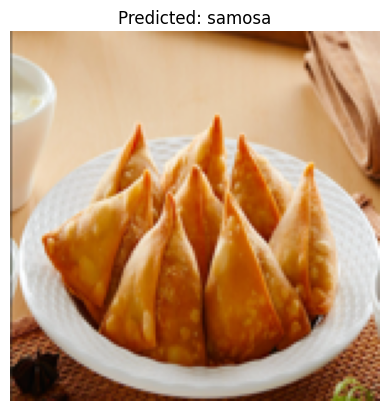

Prediction: samosa


In [ ]:
from google.colab import files
from PIL import Image, UnidentifiedImageError
import numpy as np
import matplotlib.pyplot as plt

# Pick the best model automatically based on validation accuracy
best_model_name = max(results, key=lambda k: results[k][1])  # highest val_accuracy
best_model = models[best_model_name]
print(f"Best model selected: {best_model_name}")

# Function to predict
def predict_image_upload(model, target_size=(150,150)):
    uploaded = files.upload()  # opens file picker
    for filename in uploaded.keys():
        img_path = f"/content/{filename}"
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)
            img_array = np.array(img)/255.0
            img_array = np.expand_dims(img_array, axis=0)

            pred = model.predict(img_array)
            class_idx = np.argmax(pred, axis=1)[0]
            class_label = {v:k for k,v in train_data.class_indices.items()}[class_idx]

            plt.imshow(img)
            plt.title(f"Predicted: {class_label}")
            plt.axis('off')
            plt.show()

            print(f"Prediction: {class_label}")
        except UnidentifiedImageError:
            print("Cannot open the image. Make sure it is a valid image file.")

# Run the function
predict_image_upload(best_model)